# Loan Default Prediction Analysis

**Disclaimer**

This notebook is being used to test code and is not representative of the intended final product. 
* The visuals here are minimalistic and only designed to help me structure my analysis.
* The models will be developed significantly here but may be further refined in the final product. 
* I am including some integrated SQL queries to demo the ability (I am aware that they tend to run slower than using 
only Python commands).

The dataset used is sourced from https://www.kaggle.com/datasets/nikhil1e9/loan-default and is available publicly.

## Libraries and Data Importing

In [247]:
### Libraries Importing

# data manipulation
import pandas as pd
import numpy as np

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# machine learning modeling
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn import naive_bayes
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve, auc
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

# miscellaneous
import time
import pickle
from IPython import display
from pandasql import sqldf

In [2]:
### Dataset Importing
df = pd.read_csv('Loan_default.csv')

## Data Cleaning

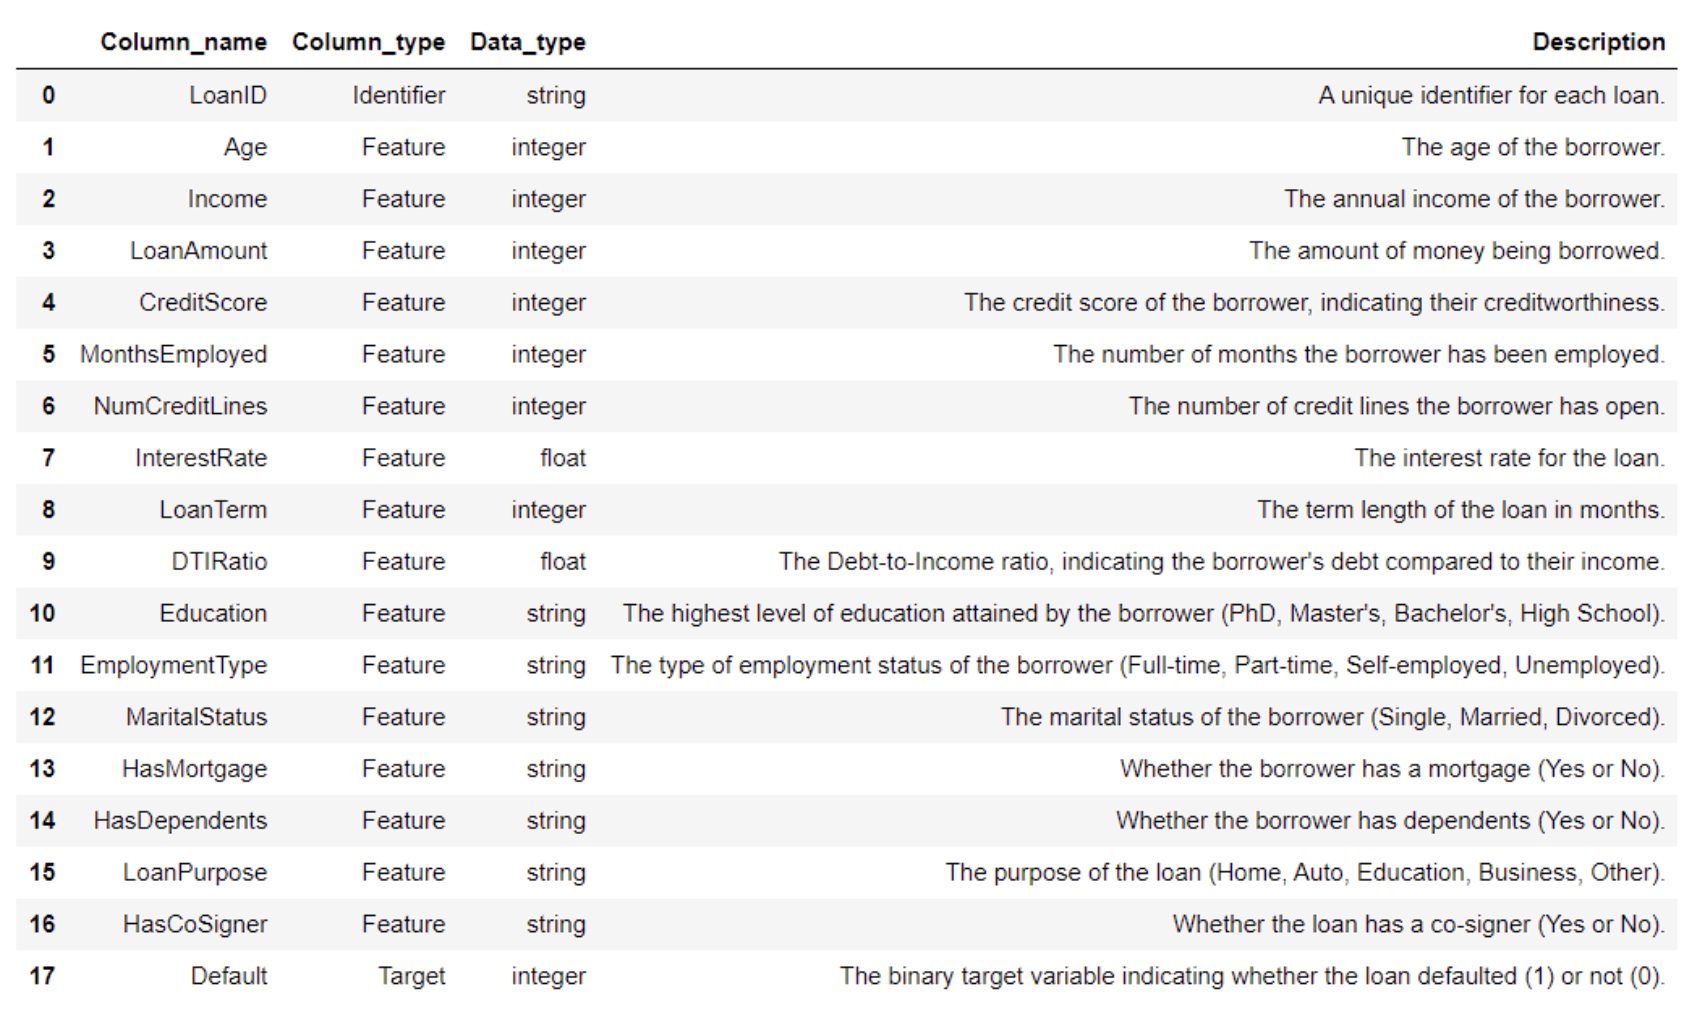

In [6]:
### Showing the descriptions of the columns
display.Image('Column_Descriptions.png')

In [8]:
### Displaying the first 5 rows of the table
df.head()

,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default
0,I38PQUQS96,56,85994,50587,520,80,4,15.23,36,0.44,Bachelor's,Full-time,Divorced,Yes,Yes,Other,Yes,0
1,HPSK72WA7R,69,50432,124440,458,15,1,4.81,60,0.68,Master's,Full-time,Married,No,No,Other,Yes,0
2,C1OZ6DPJ8Y,46,84208,129188,451,26,3,21.17,24,0.31,Master's,Unemployed,Divorced,Yes,Yes,Auto,No,1
3,V2KKSFM3UN,32,31713,44799,743,0,3,7.07,24,0.23,High School,Full-time,Married,No,No,Business,No,0
4,EY08JDHTZP,60,20437,9139,633,8,4,6.51,48,0.73,Bachelor's,Unemployed,Divorced,No,Yes,Auto,No,0


In [9]:
### Checking table dimensions
df.shape

(255347, 18)

In [10]:
### Checking for missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255347 entries, 0 to 255346
Data columns (total 18 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   LoanID          255347 non-null  object 
 1   Age             255347 non-null  int64  
 2   Income          255347 non-null  int64  
 3   LoanAmount      255347 non-null  int64  
 4   CreditScore     255347 non-null  int64  
 5   MonthsEmployed  255347 non-null  int64  
 6   NumCreditLines  255347 non-null  int64  
 7   InterestRate    255347 non-null  float64
 8   LoanTerm        255347 non-null  int64  
 9   DTIRatio        255347 non-null  float64
 10  Education       255347 non-null  object 
 11  EmploymentType  255347 non-null  object 
 12  MaritalStatus   255347 non-null  object 
 13  HasMortgage     255347 non-null  object 
 14  HasDependents   255347 non-null  object 
 15  LoanPurpose     255347 non-null  object 
 16  HasCoSigner     255347 non-null  object 
 17  Default   

There do not appear to be any missing values so I am going to move onto some initial analysis of the data.

## Initial Analysis / EDA

In [123]:
### Looking at the quickly available numeric summary
df.describe()

,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Default,IncLoanNetDiff,IncLoanPerDiff
count,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000
mean,43.498306,82499.304597,127578.865512,574.264346,59.541976,2.501036,13.492773,36.025894,0.500212,0.116128,-45079.560915,217.747982
std,14.990258,38963.013729,70840.706142,158.903867,34.643376,1.117018,6.636443,16.969330,0.230917,0.320379,80878.297292,217.835733
min,18.000000,15000.000000,5000.000000,300.000000,0.000000,1.000000,2.000000,12.000000,0.100000,0.000000,-234492.000000,3.374929
25%,31.000000,48825.500000,66156.000000,437.000000,30.000000,2.000000,7.770000,24.000000,0.300000,0.000000,-106751.000000,80.362790
50%,43.000000,82466.000000,127556.000000,574.000000,60.000000,2.000000,13.460000,36.000000,0.500000,0.000000,-44996.000000,154.672013
75%,56.000000,116219.000000,188985.000000,712.000000,90.000000,3.000000,19.250000,48.000000,0.700000,0.000000,16325.500000,267.174408
max,69.000000,149999.000000,249999.000000,849.000000,119.000000,4.000000,25.000000,60.000000,0.900000,1.000000,144721.000000,1653.245976


In [17]:
'''
Since I am ultimately interested in predicting who defaulted on a loan, let's look at 
the number of defaults vs. not defaults.
'''
df[df['Default'] == 0].count()['Default'], df[df['Default'] == 1].count()['Default']

(225694, 29653)

In [22]:
df[df['Default'] == 0].count()['Default'] / df.shape[0],\
df[df['Default'] == 1].count()['Default'] / df.shape[0]

(0.8838717509898295, 0.11612824901017048)

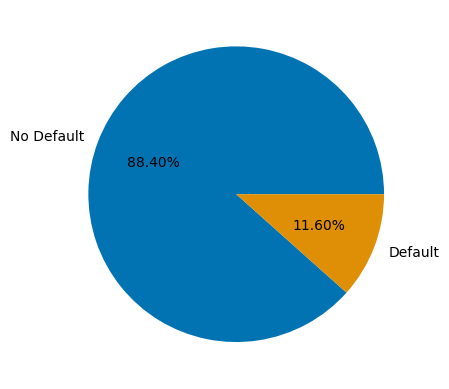

In [110]:
data = [round(df[df['Default'] == 0].count()['Default'] / df.shape[0],3)*100,\
    round(df[df['Default'] == 1].count()['Default'] / df.shape[0],3)*100]
labels = ['No Default', 'Default']
palette_color = sns.color_palette('colorblind')
plt.pie(data, labels = labels, colors = palette_color, autopct = '%1.2f%%')
plt.show()

There are 225,694 loans that did not default and 29,653 that did. 

Percentage-wise, that is approximately 88.4% did not default and 11.6% did.

To get a better idea of the distributions of the other numeric factors, I will rely on visuals (more interesting 
anyway).

<Axes: >

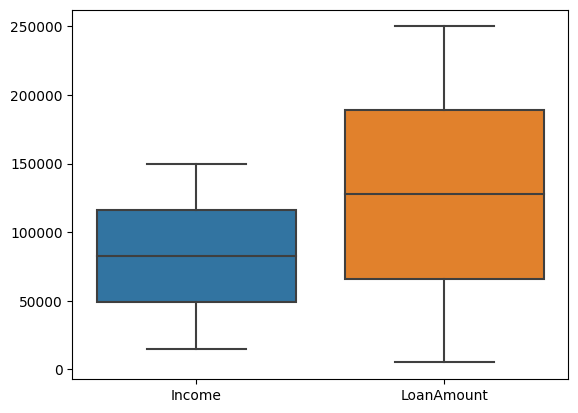

In [24]:
### Boxplot for income and loan amounts
sns.boxplot(df[['Income', 'LoanAmount']])

The average loan seems to be higher than the average income but that does not mean that those with higher 
incomes are necessarily taking out bigger loans. To see the relationship between income and loan amount, 
I will explore the distribution of the difference between income and loan amount per loan taker.

In [141]:
# Calculating net difference between income and loan amount AND 
# Calculating the percentage of income that the loan represents
'''
Note: The incLoanPerDiff (income loan percentage difference) is in terms of percent, meaning
that a value of 246.7 means that the loan is 246.7% of the loan takers income. 

The incLoanNetDiff is measuring the raw difference between a person's income and the loan
value. If the list value is positive, the person took a loan that is smaller than their 
income and if the value is negative, the loan is larger than the income.
''' 
incLoanNetDiff = []
incLoanPerDiff = []
for i in range(df.shape[0]):
    incLoanNetDiff.append(df.Income[i] - df.LoanAmount[i])
    incLoanPerDiff.append((df.LoanAmount[i] / df.Income[i])*100)

In [122]:
# adding the new lists to the table
df['IncLoanNetDiff'] = incLoanNetDiff
df['IncLoanPerDiff'] = incLoanPerDiff

In [126]:
df['IncLoanPerDiff'].describe()

count    255347.000000
mean        217.747982
std         217.835733
min           3.374929
25%          80.362790
50%         154.672013
75%         267.174408
max        1653.245976
Name: IncLoanPerDiff, dtype: float64

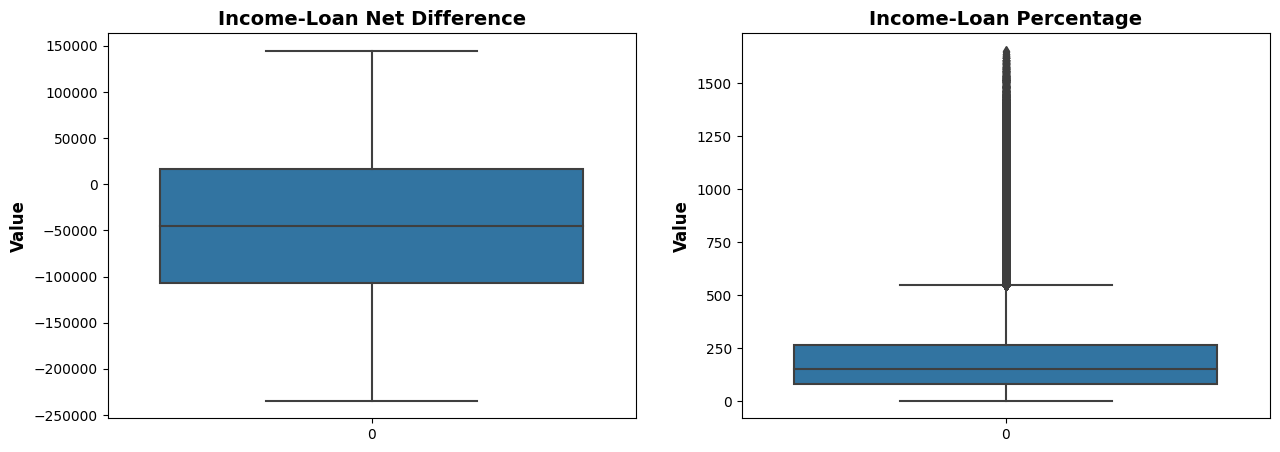

In [203]:
# Boxplots for income-loan comparison values
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
chart1 = sns.boxplot(df['IncLoanNetDiff'], ax = axes[0])
axes[0].set_title('Income-Loan Net Difference', fontsize = 14, fontweight = 'bold')
axes[0].set_ylabel('Value', fontsize = 12, fontweight = 'bold')
axes[0].set_facecolor('white')

chart2 = sns.boxplot(df['IncLoanPerDiff'], ax = axes[1])
axes[1].set_title('Income-Loan Percentage', fontsize = 14, fontweight = 'bold')
axes[1].set_ylabel('Value', fontsize = 12, fontweight = 'bold')
axes[1].set_facecolor('white')

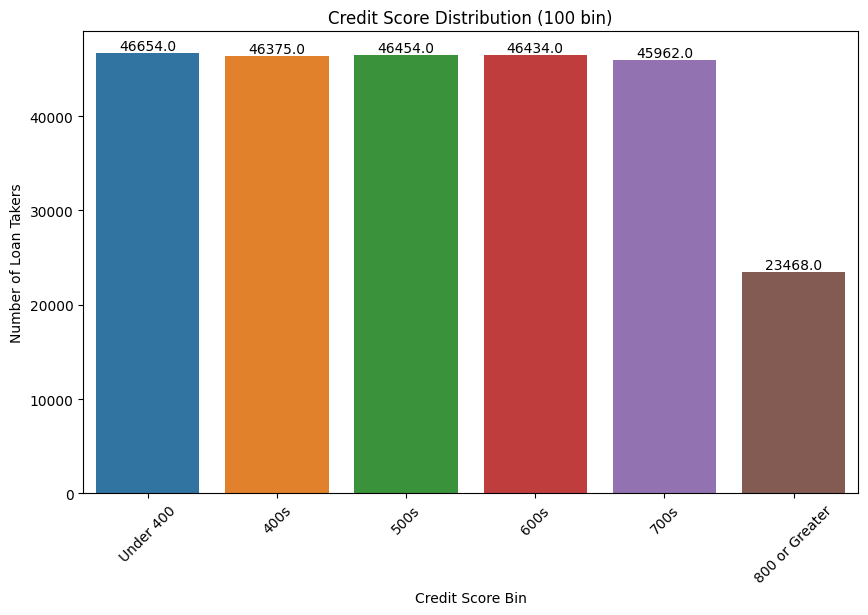

In [74]:
# Bucket bar chart for credit scores

# selecting only the credit score column
cred_scores = df.CreditScore
# Making the bins
cred_score_bins = []
for score in cred_scores:
    if score < 400:
        cred_score_bins.append('Under 400')
    elif score >= 400 and score < 500:
        cred_score_bins.append('400s')
    elif score >= 500 and score < 600:
        cred_score_bins.append('500s')
    elif score >= 600 and score < 700:
        cred_score_bins.append('600s')
    elif score >= 700 and score < 800:
        cred_score_bins.append('700s')
    else:
        cred_score_bins.append('800 or Greater')
# making the list of bins into a series
cred_score_bins = pd.Series(cred_score_bins)
# counting the counts for each bin
bin_counts = cred_score_bins.value_counts().reset_index()
reorder_dir = [0,3,1,2,4,5] # manually adjusting the order of the rows
bin_counts = bin_counts.iloc[reorder_dir]   # reordering the rows of the table
# making the bar chart
plt.figure(figsize=(10,6))
ax = sns.barplot(x = 'index', y = 'count', data = bin_counts)
plt.title('Credit Score Distribution (100 bin)')
plt.xlabel('Credit Score Bin')
plt.ylabel('Number of Loan Takers')
plt.xticks(rotation = 45)
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2.,\
        p.get_height()), ha='center', va='center', fontsize=10, color='black',\
            xytext=(0, 5), textcoords='offset points')
plt.show()

With the exception of those with a credit score over 800 or greater, there is a very similar number of loan takers
for all of the bins. The bin for those with a score of 800+ is expectantly smaller since the highest credit score is 
only 843.

In [140]:
# TESTING HOW TO USE SQL INSIDE PYTHON
sqldf('SELECT * FROM df WHERE CreditScore > 400 AND CreditScore < 500 LIMIT 3')

,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default,IncLoanNetDiff,IncLoanPerDiff
0,HPSK72WA7R,69,50432,124440,458,15,1,4.81,60,0.68,Master's,Full-time,Married,No,No,Other,Yes,0,-74008,246.748096
1,C1OZ6DPJ8Y,46,84208,129188,451,26,3,21.17,24,0.31,Master's,Unemployed,Divorced,Yes,Yes,Auto,No,1,-44980,153.415352
2,H8GXPAOS71,38,111188,177025,429,80,1,19.11,12,0.16,Bachelor's,Unemployed,Single,Yes,No,Home,Yes,0,-65837,159.212325


## Preparing for Modeling

### Preparing the data set

This section covers the alterations made to the data that will be applied across all models. Further changes
may be made in the process of developing later models (for example, rescaling the data) but these base 
preparations are just to ensure that the logistic regression model will compile (I will use it as a basis for
other models to be compared against).

In [181]:
### Changing the string columns into numeric equivalents
ed_num = []
emp_num = []
mar_num = []
mort_num = []
dep_num = []
purp_num = []
sign_num = []

# Education
for i in range(df.shape[0]):
    if df.Education[i] == 'High School':
        ed_num.append(0)
    elif df.Education[i] == "Bachelor's":
        ed_num.append(1)
    elif df.Education[i] == "Master's":
        ed_num.append(2)
    elif df.Education[i] == "PhD":
        ed_num.append(3)
# Employment Type
for i in range(df.shape[0]):
    if df.EmploymentType[i] == 'Unemployed':
        emp_num.append(0)
    elif df.EmploymentType[i] == 'Self-employed':
        emp_num.append(1)
    elif df.EmploymentType[i] == 'Part-time':
        emp_num.append(2)
    elif df.EmploymentType[i] == 'Full-time':
        emp_num.append(3)
# Marital Status
for i in range(df.shape[0]):
    if df.MaritalStatus[i] == 'Single':
        mar_num.append(0)
    elif df.MaritalStatus[i] == 'Married':
        mar_num.append(1)
    elif df.MaritalStatus[i] == 'Divorced':
        mar_num.append(2)
# Has Mortage
for i in range(df.shape[0]):
    if df.HasMortgage[i] == 'Yes':
        mort_num.append(1)
    elif df.HasMortgage[i] == 'No':
        mort_num.append(0)
# Has Dependents
for i in range(df.shape[0]):
    if df.HasDependents[i] == 'Yes':
        dep_num.append(1)
    elif df.HasDependents[i] == 'No':
        dep_num.append(0)
# Loan Purpose
for i in range(df.shape[0]):
    if df.LoanPurpose[i] == 'Home':
        purp_num.append(0)
    elif df.LoanPurpose[i] == 'Education':
        purp_num.append(1)
    elif df.LoanPurpose[i] == 'Business':
        purp_num.append(2)
    elif df.LoanPurpose[i] == 'Auto':
        purp_num.append(3)
    elif df.LoanPurpose[i] == 'Other':
        purp_num.append(4)
# Has Co-signer
for i in range(df.shape[0]):
    if df.HasCoSigner[i] == 'Yes':
        sign_num.append(1)
    elif df.HasCoSigner[i] == 'No':
        sign_num.append(0)
    

In [185]:
### Adding the new numeric columns and removing the categorical ones
original_table = df # to save a copy of the original table

df.Education = ed_num
df.EmploymentType = emp_num
df.MaritalStatus = mar_num
df.HasMortgage = mort_num
df.HasDependents = dep_num
df.LoanPurpose = purp_num
df.HasCoSigner = sign_num

In [187]:
# Feature table
X = df.drop(columns = ['LoanID', 'Default'])
# Response column
y = df.Default
# Splitting the data set (80-20 train-test, 80-20 train-validate)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 8413)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 8413)

In [198]:
# Logistic regression
logreg_model_1 = LogisticRegression(max_iter = 10000)   # instantiating the model   
logreg_model_1.fit(X_train, y_train)    # fitting the model to the train set
logreg_y_pred_1 = logreg_model_1.predict(X_val) # making a prediction based on validation set
logreg_model_1_accuracy = accuracy_score(y_val, logreg_y_pred_1)    # accuracy
logreg_model_1_recall = recall_score(y_val, logreg_y_pred_1)    # recall
logreg_model_1_precision = precision_score(y_val, logreg_y_pred_1)  # precision
logreg_model_1_f1 = f1_score(y_val, logreg_y_pred_1)    # f1 score

In [199]:
[logreg_model_1_accuracy, logreg_model_1_recall, logreg_model_1_precision,
 logreg_model_1_f1]

[0.8865527707068729,
 0.04289658101507751,
 0.6121212121212121,
 0.08017463782496527]

### Logistic Regression Model #1 Results (train + validation sets)

All results are rounded to 5 significant digits.
* Accuracy: 0.88655
* Recall: 0.04290
* Precision: 0.61212
* F1-Score: 0.080167

The accuracy is reasonably high but the other metrics are too low. In particular, since preventing false negatives, meaning 
cases where the model says that a person will not default but they actually will, is most important, this logistic regression 
model is nowhere near powerful enough.

## More Models

I will now develop and assess several other modeling approaches:
* K-nearest Neighbors
* Decision Tree
* Random Forest
* Naive Bayes
* XGBoost

To enhance each of the models' performances, I will also rescale the data to remove scale-related bias. Once this is completed,
I will also re-evaluate the logistic regression model to check how rescaling affected the model's performance.

If the models still are not performing sufficiently well, I will rebalance the predicted classes since in the raw data, there are far more cases where the loan did not default than where it did.

In [216]:
### Scaling the data
scaler = StandardScaler()
X_scale = scaler.fit_transform(X)

### Resplitting the data
X_train, X_test, y_train, y_test = train_test_split(X_scale, y, test_size = 0.2, random_state = 8413)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 8413)

In [242]:
### Setting up the models (I have them in order of anticipated success)
models = {
    "Naive Bayes Model": GaussianNB(),
    "KNN Model": KNeighborsClassifier(),  
    "Decision Tree Model": DecisionTreeClassifier(random_state = 8413),
    "Random Forest Model": RandomForestClassifier(random_state = 8413),
    "XGBoost Model": XGBClassifier(random_state = 8413)
}

In [243]:
### Making a dictionary to track all of the model scores
metrics = {"Model": [],
          "Accuracy": [],
          "Precision": [],
          "Recall": [],
          "F1-Score": [],
          "ROC_AUC": []}

In [244]:
### Cross validating the models 
for model_name, model in models.items():
    accuracies = cross_val_score(model, X_train, y_train, cv = 3, scoring = 'accuracy')
    precisions = cross_val_score(model, X_train, y_train, cv = 3, scoring = 'precision')
    recalls = cross_val_score(model, X_train, y_train, cv = 3, scoring = 'recall')
    f1_scores = cross_val_score(model, X_train, y_train, cv = 3, scoring = 'f1')
    roc_auc_scores = cross_val_score(model, X_train, y_train, cv = 3, scoring = 'roc_auc')
    
    # Adding results to the metrics dictionary
    metrics['Model'].append(model_name)
    metrics['Accuracy'].append(np.mean(accuracies))
    metrics['Precision'].append(np.mean(precisions))
    metrics['Recall'].append(np.mean(recalls))
    metrics['F1-Score'].append(np.mean(f1_scores))
    metrics['ROC_AUC'].append(np.mean(roc_auc_scores))

In [245]:
### Changing the metrics dictionary into a dataframe for viewing
model_scores_df = pd.DataFrame(metrics)
model_scores_df

,Model,Accuracy,Precision,Recall,F1-Score,ROC_AUC
0,Naive Bayes Model,0.860581,0.335240,0.202927,0.252802,0.725687
1,KNN Model,0.875034,0.345220,0.083697,0.134721,0.622016
2,Decision Tree Model,0.803660,0.201822,0.233142,0.216353,0.555923
3,Random Forest Model,0.885315,0.578764,0.050061,0.092139,0.726914
4,XGBoost Model,0.883785,0.500592,0.086645,0.147689,0.733580


This is not really good enough so I will try rebalancing the classes.

In [248]:
### Using SMOTE to rebalance the classes
smote = SMOTE(random_state = 8413)
X_rebal, y_rebal = smote.fit_resample(X_scale, y)

In [249]:
### Redoing the modeling

### Resplitting the data
X_train, X_test, y_train, y_test = train_test_split(X_rebal, y_rebal, test_size = 0.2, random_state = 8413)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 8413)
### Making a dictionary to track all of the model scores
metrics_2 = {"Model": [],
          "Accuracy": [],
          "Precision": [],
          "Recall": [],
          "F1-Score": [],
          "ROC_AUC": []}
for model_name, model in models.items():
    accuracies = cross_val_score(model, X_train, y_train, cv = 3, scoring = 'accuracy')
    precisions = cross_val_score(model, X_train, y_train, cv = 3, scoring = 'precision')
    recalls = cross_val_score(model, X_train, y_train, cv = 3, scoring = 'recall')
    f1_scores = cross_val_score(model, X_train, y_train, cv = 3, scoring = 'f1')
    roc_auc_scores = cross_val_score(model, X_train, y_train, cv = 3, scoring = 'roc_auc')
    
    # Adding results to the metrics dictionary
    metrics_2['Model'].append(model_name)
    metrics_2['Accuracy'].append(np.mean(accuracies))
    metrics_2['Precision'].append(np.mean(precisions))
    metrics_2['Recall'].append(np.mean(recalls))
    metrics_2['F1-Score'].append(np.mean(f1_scores))
    metrics_2['ROC_AUC'].append(np.mean(roc_auc_scores))

In [250]:
### Changing the metrics dictionary into a dataframe for viewing
model_2_scores_df = pd.DataFrame(metrics_2)
model_2_scores_df

,Model,Accuracy,Precision,Recall,F1-Score,ROC_AUC
0,Naive Bayes Model,0.671682,0.711538,0.578201,0.637977,0.747990
1,KNN Model,0.796849,0.719033,0.974920,0.827649,0.915881
2,Decision Tree Model,0.826867,0.819112,0.839309,0.829087,0.826859
3,Random Forest Model,0.920519,0.942112,0.896214,0.918589,0.973185
4,XGBoost Model,0.928900,0.986412,0.869875,0.924485,0.964703


The XGBoost model seems to be performing very well and will now be tested on the validation set.

**Note:** I will be working on the hyperparameter tuning later.

In [253]:
### XGBoost Model (using train and validation sets)
final_model = XGBClassifier(
    objective = 'binary:logistic',
    n_estimators = 100, 
    max_depth = 3, 
    learning_rate = 0.1,
    random_state = 8413
)

final_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=8413, ...)

In [264]:
### Making predictions and evaluating the model
y_val_pred = final_model.predict(X_val)
val_acc = accuracy_score(y_val, y_val_pred)
val_prec = precision_score(y_val, y_val_pred)
val_rec = recall_score(y_val, y_val_pred)
val_f1 = f1_score(y_val, y_val_pred)
val_roc_auc = roc_auc_score(y_val, y_val_pred)


final_model_val_metrics_table = pd.DataFrame({
    'Accuracy': [val_acc],
    'Precision': [val_prec],
    'Recall': [val_rec],
    'F1': [val_f1],
    'ROC_AUC': [val_roc_auc]
})

In [265]:
### Displaying the metrics for the XGBoost model
final_model_val_metrics_table

,Accuracy,Precision,Recall,F1,ROC_AUC
0,0.898923,0.953887,0.837263,0.891778,0.898603


This is still a solid performance but it is low enough that it is worth exploring other hyperparameters later.

Still, I will now test out the test data.

In [267]:
y_test_pred = final_model.predict(X_test)
test_acc = accuracy_score(y_val, y_val_pred)
test_prec = precision_score(y_val, y_val_pred)
test_rec = recall_score(y_val, y_val_pred)
test_f1 = f1_score(y_val, y_val_pred)
test_roc_auc = roc_auc_score(y_val, y_val_pred)


final_model_test_metrics_table = pd.DataFrame({
    'Accuracy': [test_acc],
    'Precision': [test_prec],
    'Recall': [test_rec],
    'F1': [test_f1],
    'ROC_AUC': [test_roc_auc]
})

final_model_test_metrics_table

,Accuracy,Precision,Recall,F1,ROC_AUC
0,0.898923,0.953887,0.837263,0.891778,0.898603
